In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [3]:
# calculate N*
# must be in umol/kg, so first convert
def convert_uM_to_umol_per_kg(uM, salinity, temperature, pressure):
    """
    Converts concentration from µM (µmol/L) to µmol/kg.
    """
    CT = gsw.conversions.CT_from_t(salinity,temperature,pressure)
    density = gsw.density.rho(np.array(salinity), CT, np.array(pressure))

    umol_per_kg = uM / (density / 1000)
    return umol_per_kg
    
# N∗=(N−16×P)+2.9
no3 = convert_uM_to_umol_per_kg(obs['NO3 (uM)'], obs['salinity (g kg-1)'], obs['temperature (degC)'], obs['pressure (dbar)'])
po4 = convert_uM_to_umol_per_kg(obs['PO4 (uM)'], obs['salinity (g kg-1)'], obs['temperature (degC)'], obs['pressure (dbar)'])
obs['Nstar'] = (no3-(16*po4)+2.9)*0.87 # equation 13 in Gruber & Sarmiento (1997)
 
# calculate spice
obs['spice'] = gsw.spiciness0(obs['salinity (g kg-1)'], obs['temperature (degC)'])

In [4]:
# check Nstar calc (typical range for the north pacific is -5 to -10 umol/kg)
print('max = %s, min = %s, mean = %s' % (np.max(obs['NO3 (uM)']),np.min(obs['NO3 (uM)']),np.mean(obs['NO3 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(obs['PO4 (uM)']),np.min(obs['PO4 (uM)']),np.mean(obs['PO4 (uM)'])))
print('max = %s, min = %s, mean = %s' % (np.max(obs['Nstar']),np.min(obs['Nstar']),np.mean(obs['Nstar'])))

max = 855.3548817981541, min = 0.0, mean = 19.855862047338544
max = 108.0, min = 0.0, mean = 3.095947630477215
max = 65.68716081358126, min = -229.06683050624193, mean = -22.520988723273653


In [11]:
no3 = convert_uM_to_umol_per_kg(obs['NO3 (uM)'][148210], obs['salinity (g kg-1)'][148210], obs['temperature (degC)'][148210], obs['pressure (dbar)'][148210])
po4 = convert_uM_to_umol_per_kg(obs['PO4 (uM)'][148210], obs['salinity (g kg-1)'][148210], obs['temperature (degC)'][148210], obs['pressure (dbar)'][148210])
(no3-(16*po4)+2.9)*0.87 # equation 13 in Gruber & Sarmiento (1997)

nan

In [12]:
obs.columns

Index(['Unnamed: 0', 'time', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Al (nM)',
       'Ba (nM)', 'Cd (nM)', 'Co (nM)', 'Cu (nM)', 'Fe (nM)', 'Ga (nM)',
       'Mn (nM)', 'Ni (nM)', 'Pb (nM)', 'Zn (nM)', 'source', 'Nstar', 'spice'],
      dtype='object')

#### remove Salish Sea and Johnstone Strait points

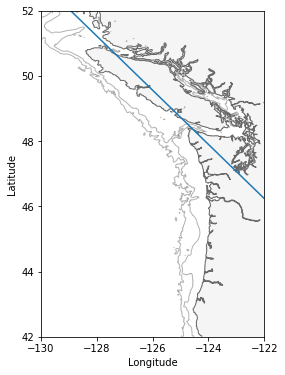

In [13]:
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m
y = m*x+b
ax.plot(x,y)

In [14]:
ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

## Functions

In [15]:
def cluster(key, n):
    # Drop rows with NaN values in the 'salinity' column
    df_clean = obs.dropna(subset=[key])

    # Selecting the property to cluster
    X = df_clean[[key]].values

    # Applying K-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X)

    # Assign the cluster labels back to the DataFrame
    df_clean['Cluster'] = kmeans.labels_

    return df_clean[['time','longitude (degrees_east)','latitude (degrees_north)', 'depth (m)',key,'Cluster']]

def multi_cluster(df, keys, n):
    # Drop rows with NaN values in the clustering columns
    df_clean = df.dropna(subset=keys)

    # Selecting the properties to cluster
    X = df_clean[keys].values

    # Normalizing the data
    # you need to do this because you dont want a key with higher values to be more important for clustering
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Applying K-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X_scaled)

    # Assign the cluster labels back to the DataFrame
    df_clean['Cluster'] = kmeans.labels_

    return df_clean
    
def z_cluster_plot(data, key, n, ax, colour):
    xmin, xmax = np.min(data[key]), np.max(data[key])
    # if xmin < 0:
    #     xmin = 0
    # ymin = np.min(data['depth (m)'])

    cluster_data = data[data['Cluster'] == n]
    
    ax.scatter(cluster_data[key], cluster_data['depth (m)']*-1, s=1,c=colour)

    ax.set_ylabel('Depth (m)')
    ax.set_ylim([-1000,10])
    ax.set_xlim([xmin,xmax])

    plt.tight_layout()

def xy_cluster_plot(data, n, ax, colour):
    cluster_data = data[data['Cluster'] == n]
            
    # Increase font size
    plt.rcParams['font.size'] = 14

    # Make plot area
    ax.set_extent(xlim + ylim)

    # Draw coastline
    ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

    # Draw box
    ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

    # add points
    ax.scatter(cluster_data['longitude (degrees_east)'], cluster_data['latitude (degrees_north)'], s=1,c=colour, transform=crs.PlateCarree(),zorder=7)

    ax.set_title(n)

    plt.tight_layout()

def time_cluster_plot(Cdata):
    # clusters in time versus depth
    time = pd.to_datetime(Cdata.time)
    Cdata['month']=[time[i].month for i in Cdata.index]

    ntot = [len(Cdata[(Cdata.month==mo)]) for mo in np.arange(1,13)] # montly total count

    fig,ax = plt.subplots(1,1,figsize=[6,2])

    for k in Cdata['Cluster'].unique():
        ax.plot(np.arange(1,13), [len(Cdata[(Cdata.Cluster==k) & (Cdata.month==mo)])/(ntot[mo-1]+1) for mo in np.arange(1,13)], c=colours[k])
    ax2 = ax.twinx()
    ax2.plot(np.arange(1,13),ntot,'k--',alpha=0.5)

    ax2.set_ylabel('Total Count')
    ax.set_xlabel('Month')
    ax.set_ylabel('Fraction of Count')

In [16]:
colours = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']

# Single tracer clustering

In [17]:
N=4
xlim, ylim = [-145.5, -120.2], [30, 60]

In [18]:
df_cluster = cluster('temperature (degC)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'temperature (degC)', i, ax[i], colours[i])

Error in callback <function flush_figures at 0x7f099f2183a0> (for post_execute):


KeyboardInterrupt: 

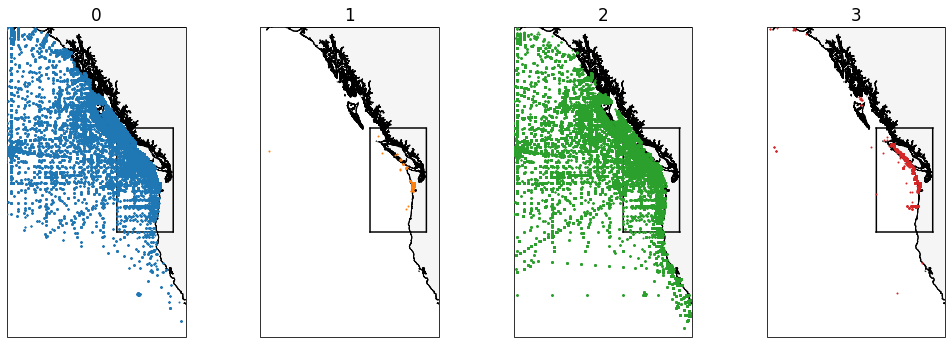

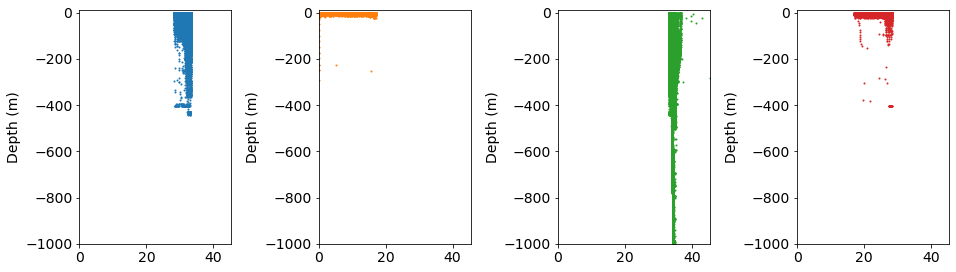

In [13]:
df_cluster = cluster('salinity (g kg-1)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'salinity (g kg-1)', i, ax[i], colours[i])

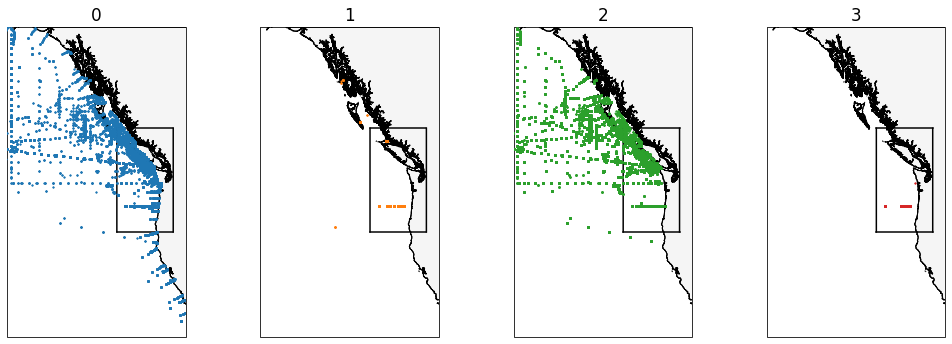

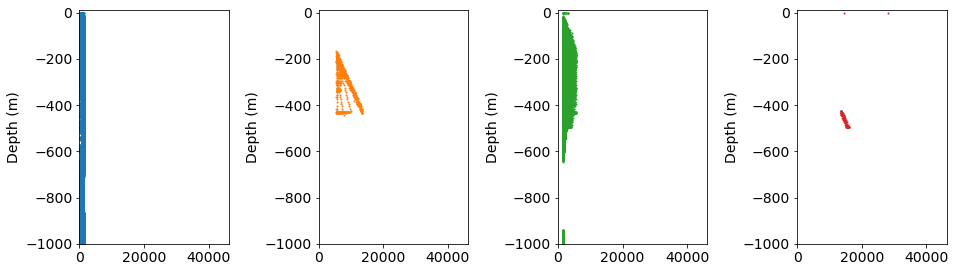

In [14]:
df_cluster = cluster('DO (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'DO (uM)', i, ax[i], colours[i])

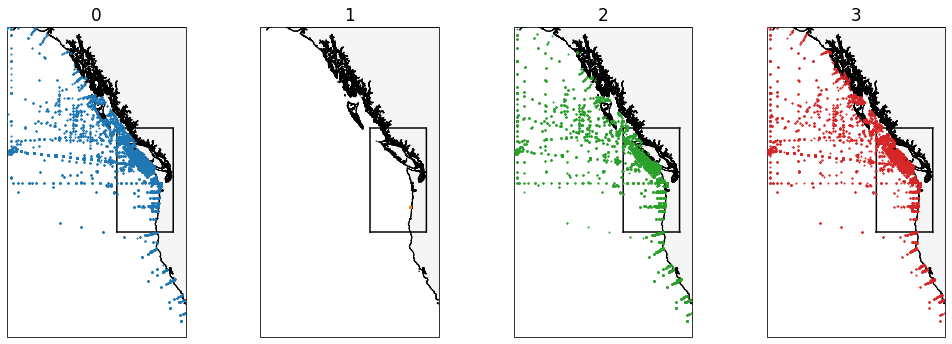

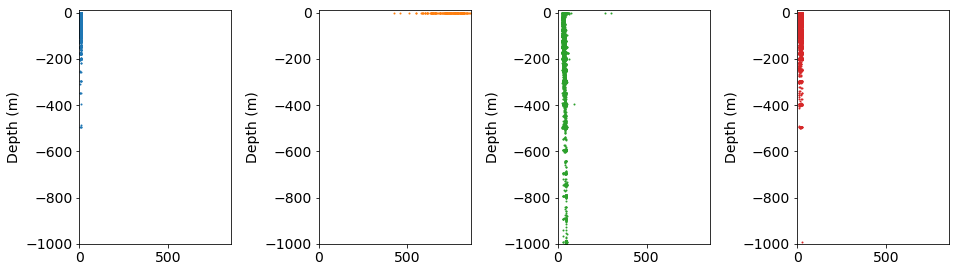

In [15]:
df_cluster = cluster('NO3 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'NO3 (uM)', i, ax[i], colours[i])

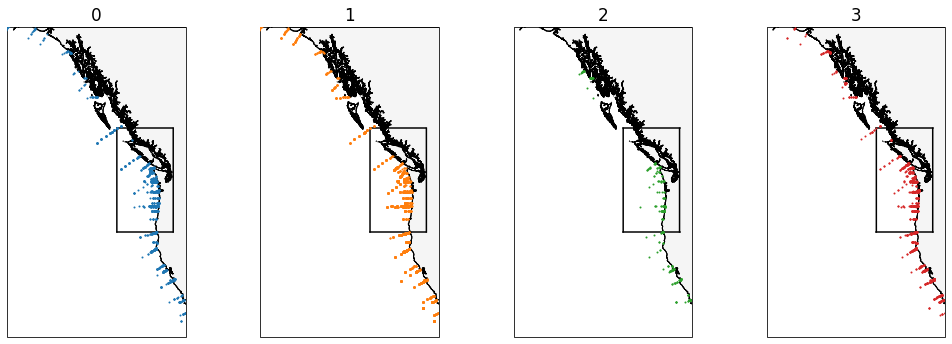

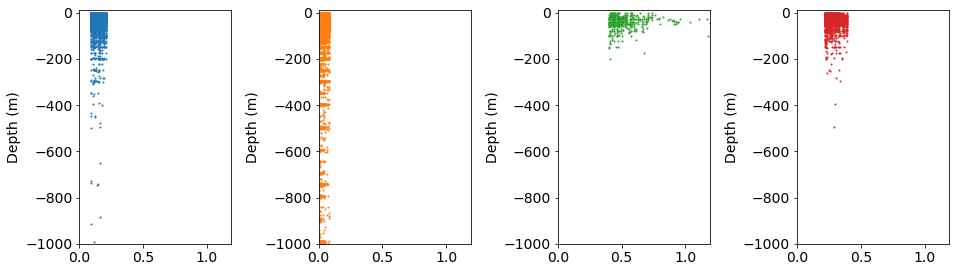

In [16]:
df_cluster = cluster('NO2 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'NO2 (uM)', i, ax[i], colours[i])

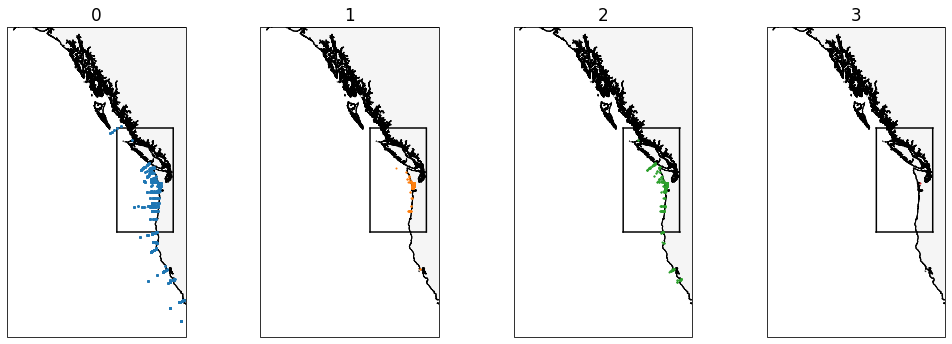

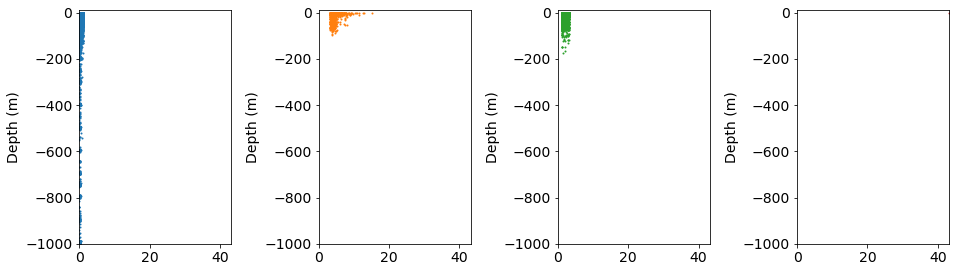

In [17]:
df_cluster = cluster('NH4 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'NH4 (uM)', i, ax[i], colours[i])

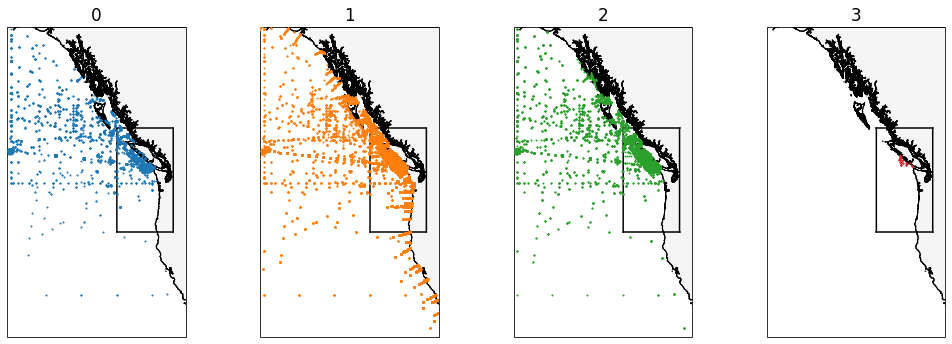

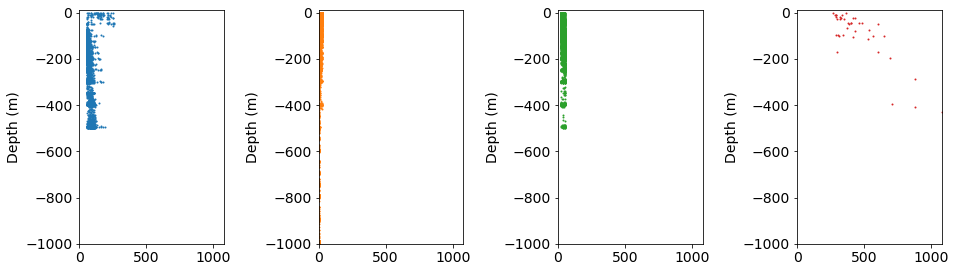

In [18]:
df_cluster = cluster('PO4 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'PO4 (uM)', i, ax[i], colours[i])

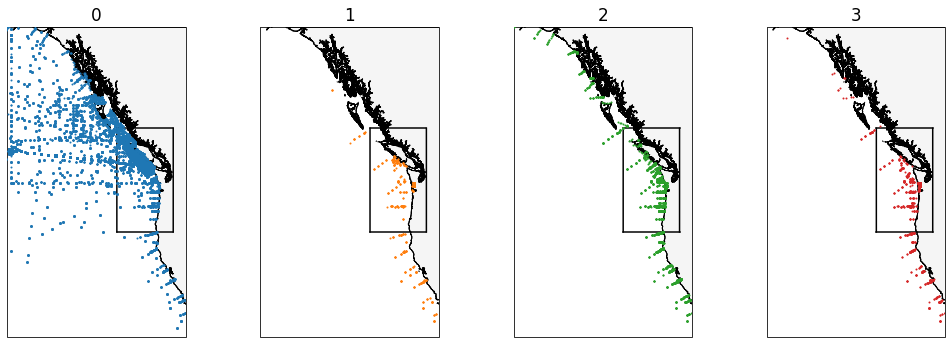

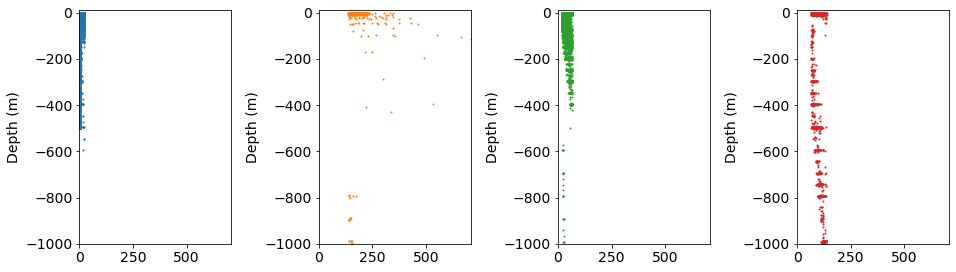

In [19]:
df_cluster = cluster('SiO4 (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'SiO4 (uM)', i, ax[i], colours[i])

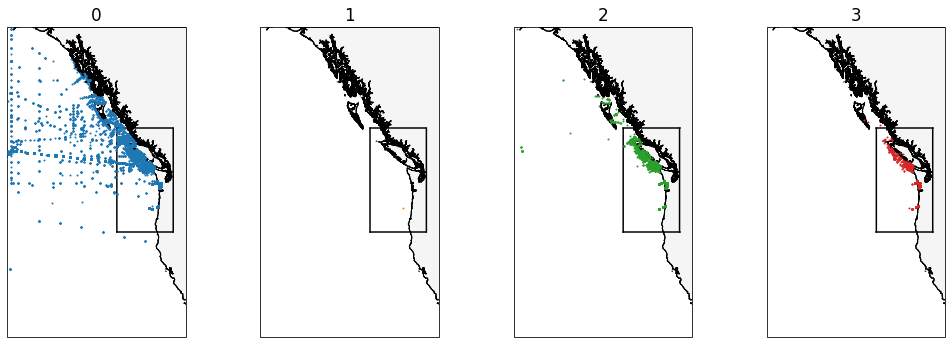

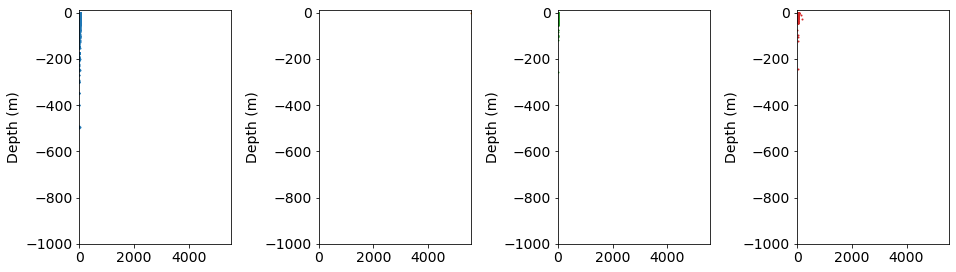

In [20]:
df_cluster = cluster('Chl (mg m-3)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Chl (mg m-3)', i, ax[i], colours[i])

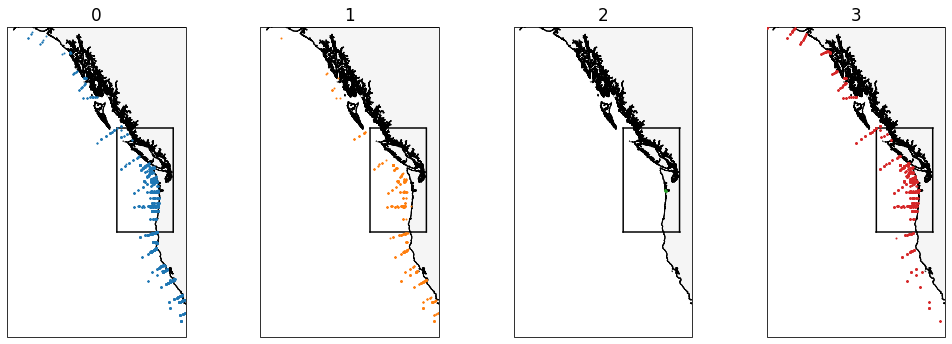

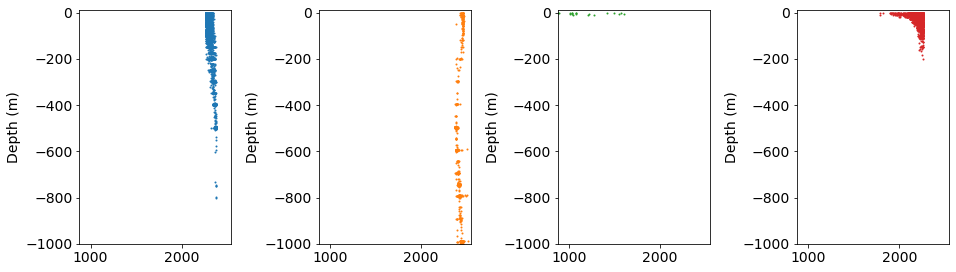

In [21]:
df_cluster = cluster('TA (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'TA (uM)', i, ax[i], colours[i])

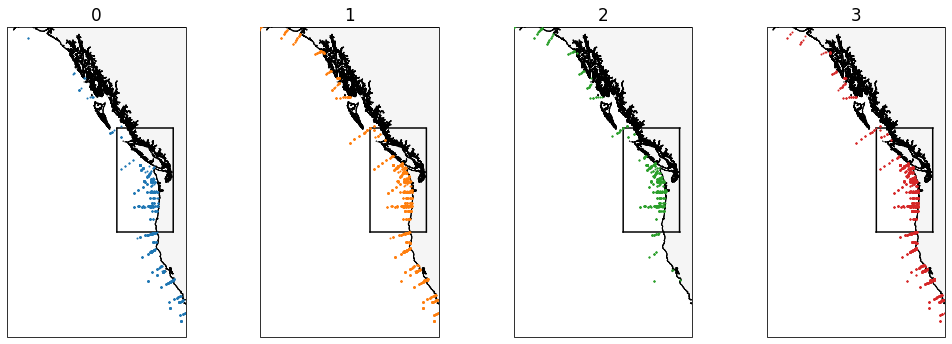

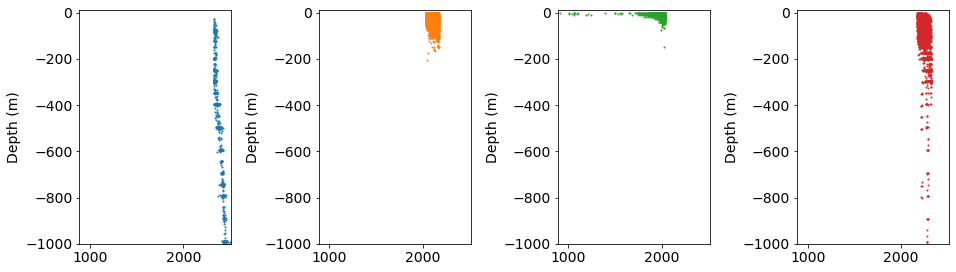

In [22]:
df_cluster = cluster('DIC (uM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'DIC (uM)', i, ax[i], colours[i])

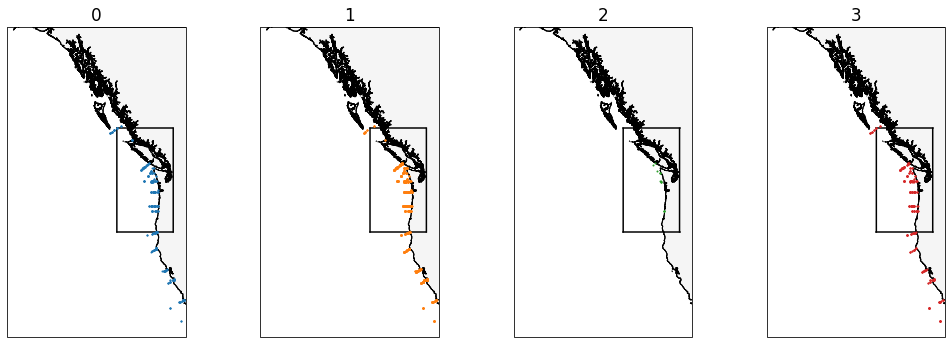

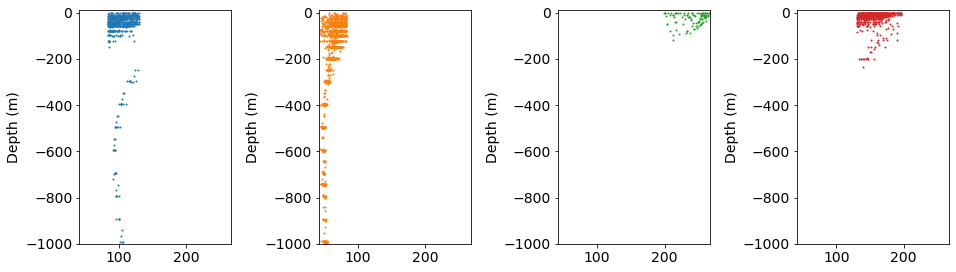

In [23]:
df_cluster = cluster('Carbonate',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Carbonate', i, ax[i], colours[i])

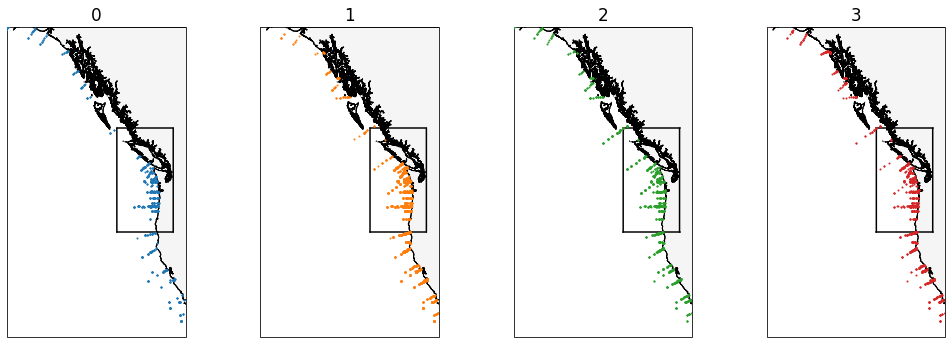

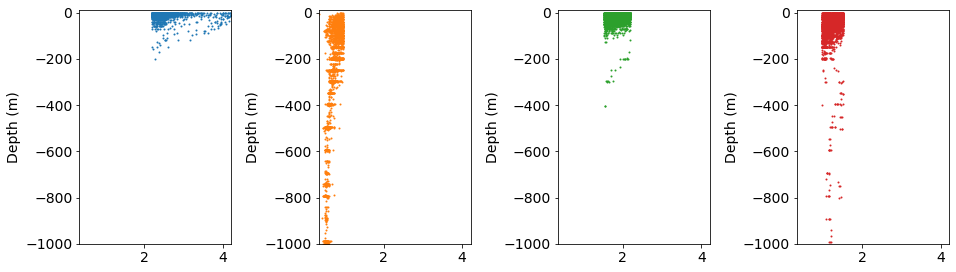

In [24]:
df_cluster = cluster('Aragonite',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Aragonite', i, ax[i], colours[i])

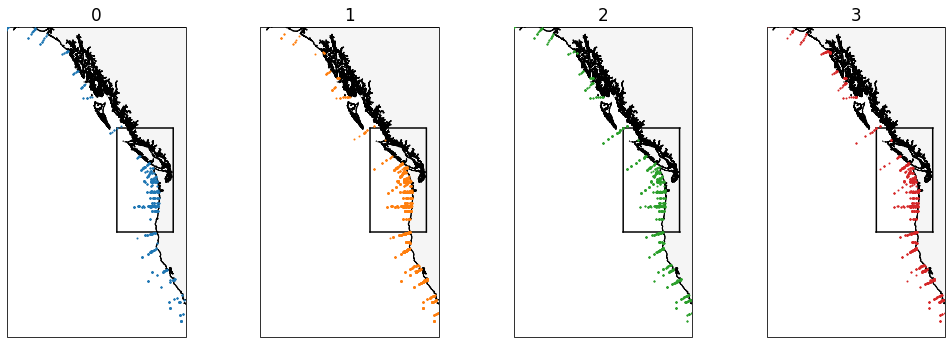

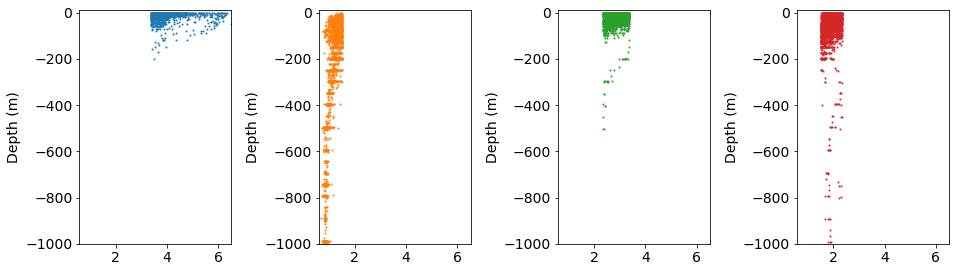

In [25]:
df_cluster = cluster('Calcite',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Calcite', i, ax[i], colours[i])

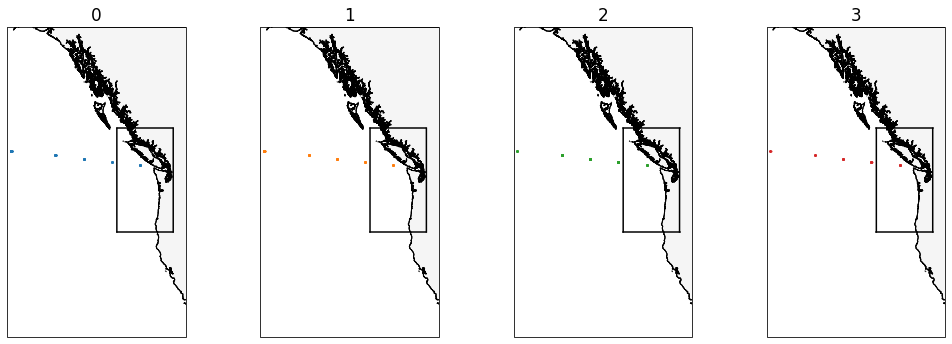

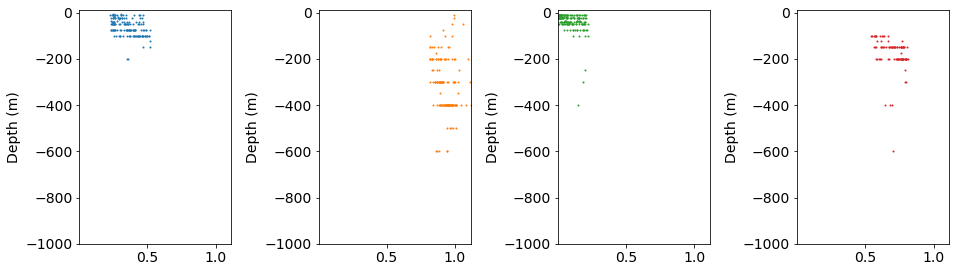

In [26]:
df_cluster = cluster('Cd (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Cd (nM)', i, ax[i], colours[i])

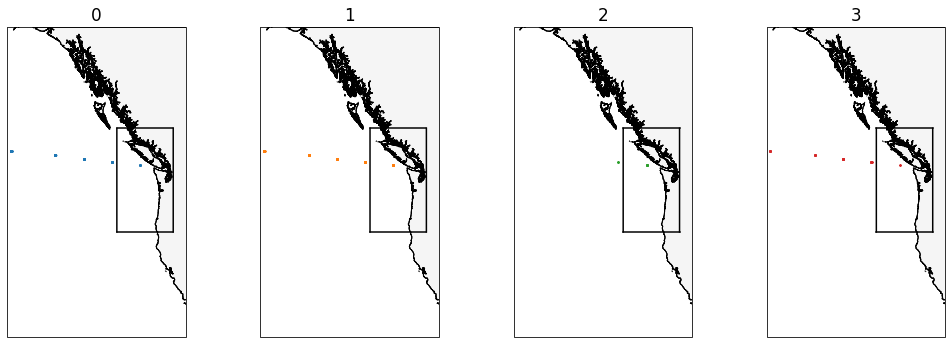

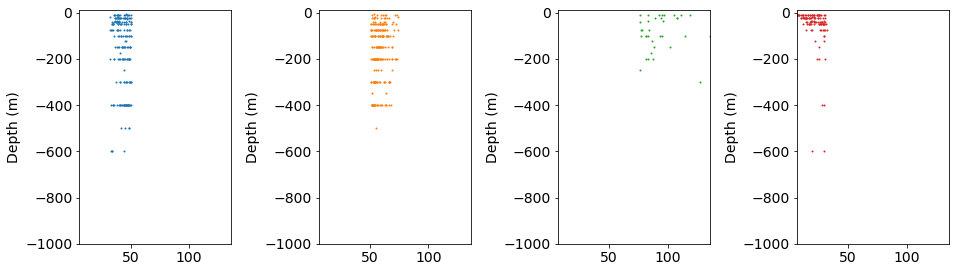

In [27]:
df_cluster = cluster('Co (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Co (nM)', i, ax[i], colours[i])

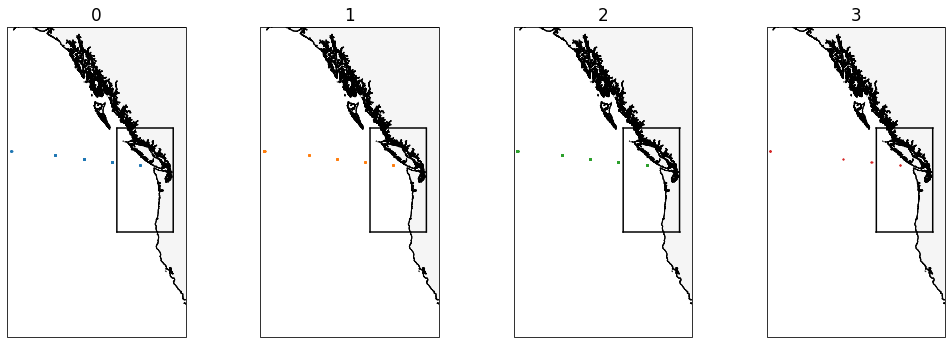

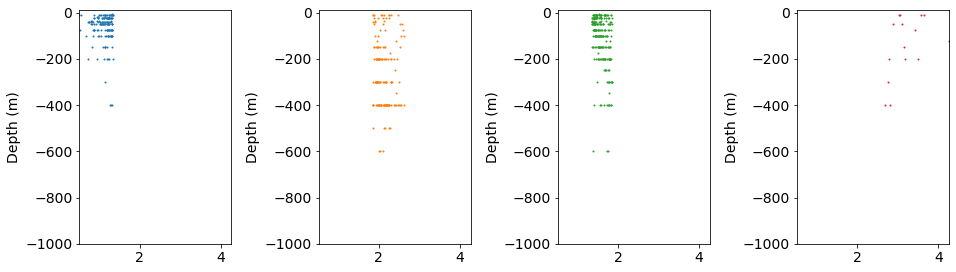

In [28]:
df_cluster = cluster('Cu (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Cu (nM)', i, ax[i], colours[i])

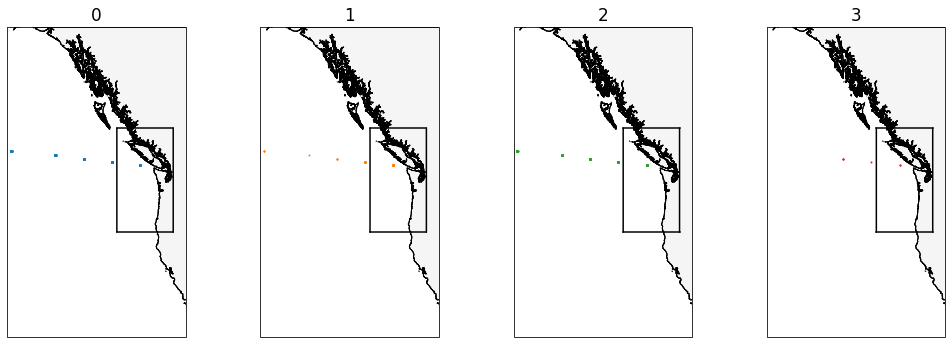

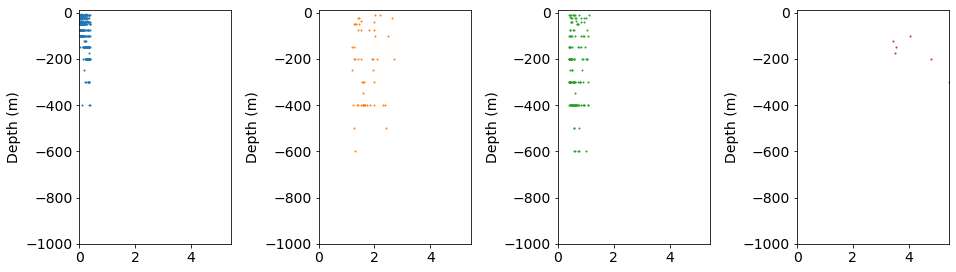

In [29]:
df_cluster = cluster('Fe (nM)',N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

for i in range(N):
    z_cluster_plot(df_cluster, 'Fe (nM)', i, ax[i], colours[i])

# Multi property clustering

### Temperature - Salinity
0 (blue) - top 400 m, central temperature range (~5-10). Largest fraction of results, no clear seasonal cycle.  <br>
1 (orange) - top 400 m, warmer (warmer than 10). Slightly more prominent in the winter (downwelling?) <br>
2 (green) - Fresher water source, located around river mouths. Juts further out to sea around the newport line. Smallest fraction of results, no clear seasonal cycle. <br>
3 (red) - Deepest (only one to go deeper than 500 m) and coldest (less than 5), similar salinity range to 0 and 1. Slightly more prominent in the summer (upwelling?) <br>

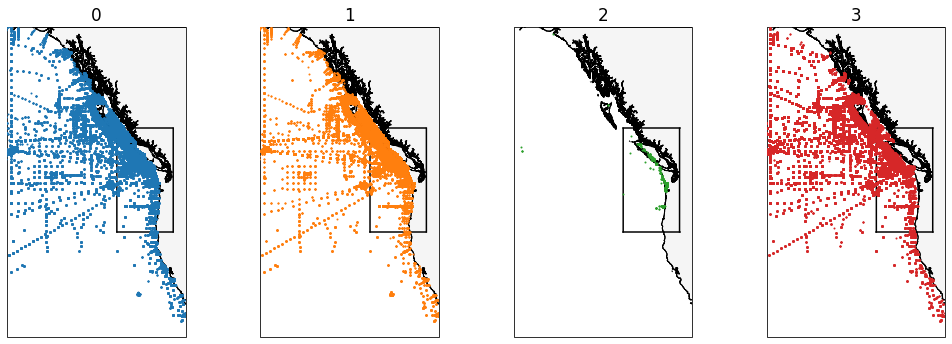

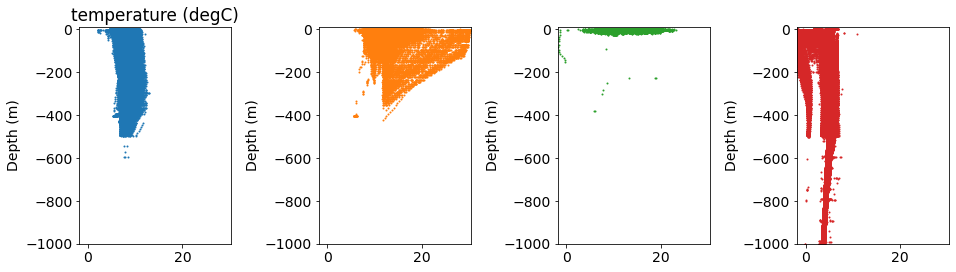

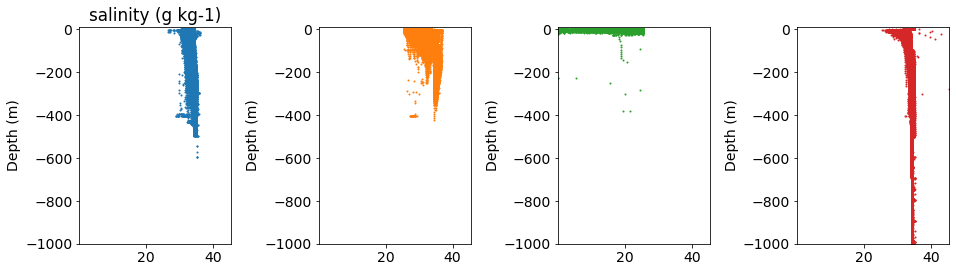

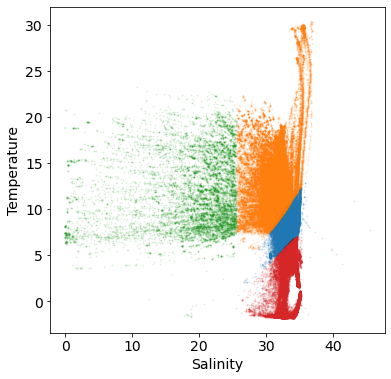

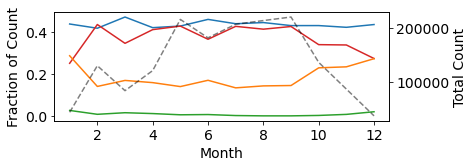

In [30]:
keys = ['temperature (degC)', 'salinity (g kg-1)']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(N):
    ax.scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['temperature (degC)'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])
ax.set_ylabel('Temperature')
ax.set_xlabel('Salinity')

time_cluster_plot(df_cluster)
    

### Temperature - Salinity - DO
0 (blue) - <br>
1 (orange) - <br>
2 (green) - <br>
3 (red) - <br>

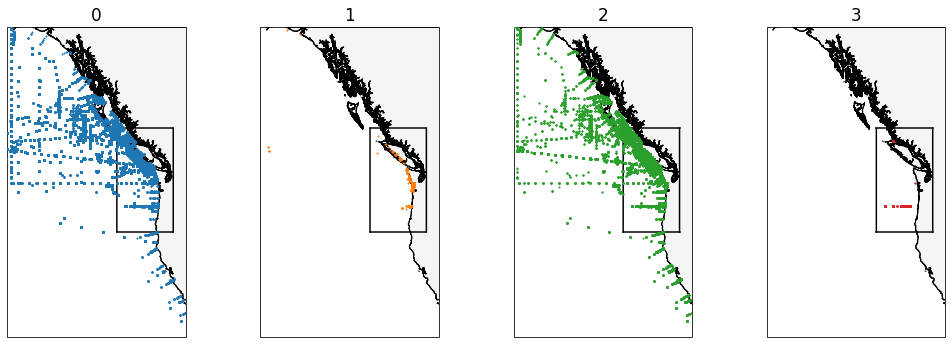

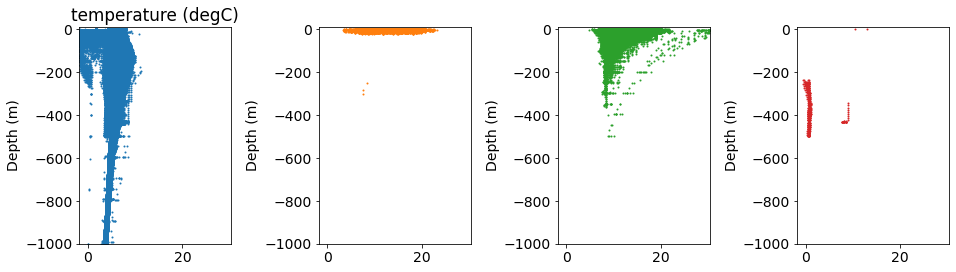

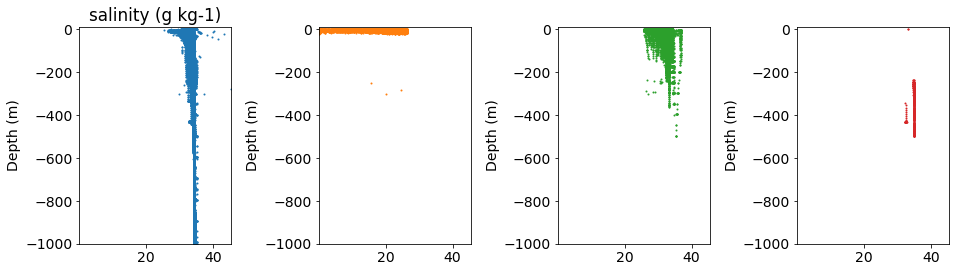

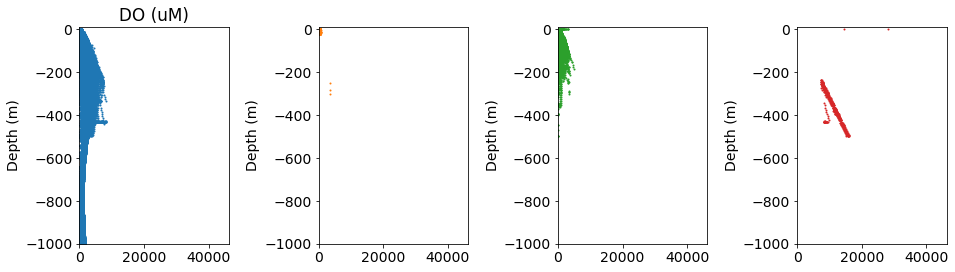

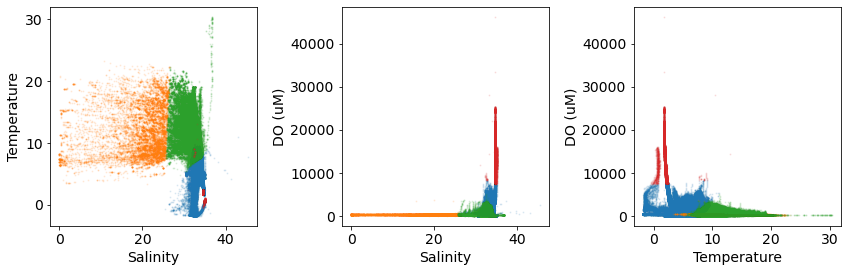

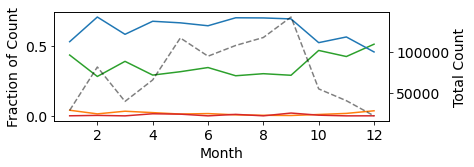

In [31]:
keys = ['temperature (degC)', 'salinity (g kg-1)', 'DO (uM)']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[2])
for i in range(N):
    z_cluster_plot(df_cluster, keys[2], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,3,figsize = (12,4))
for i in range(N):
    ax[0].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['temperature (degC)'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])
    ax[1].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['DO (uM)'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])
    ax[2].scatter(df_cluster['temperature (degC)'][df_cluster.Cluster == i],df_cluster['DO (uM)'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])

ax[0].set_ylabel('Temperature')
ax[1].set_ylabel('DO (uM)')
ax[2].set_ylabel('DO (uM)')

ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Salinity')
ax[2].set_xlabel('Temperature')

plt.tight_layout()

time_cluster_plot(df_cluster)


### Temperature - Salinity - Nstar
All Nstar -ve which means that there is denitrification present (ie. Nstar sink) <br>
0 (blue) - Present along the entire coast. Large temperature range and Nstart pretty close to 0, distinct from 1 based upon higher salinity. No clear seasonal cycle. <br>
1 (orange) - Fresh, Nstar of 0, large temperature range. Right at large river mouths. Seems to be high in winter and low in summer. <br>
2 (green) - Distinct (lowest) Nstar, overlap with salinity of 0 and 3 and colder end of 0 temperature range. Predominantly in waters north of the columbia river. No seasonal cycle. <br>
3 (red) - All deep water measurements fit in this group, distinct (colder) temperature range from 0 and 3. No clear seasonal cycle. <br>


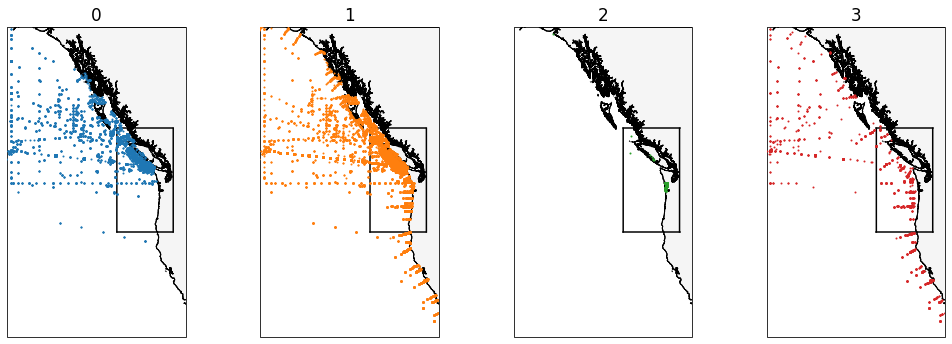

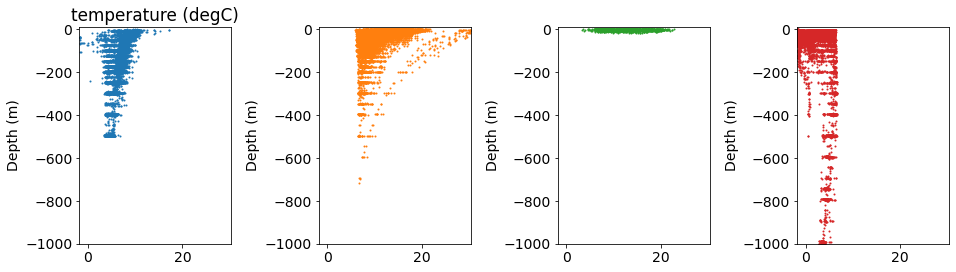

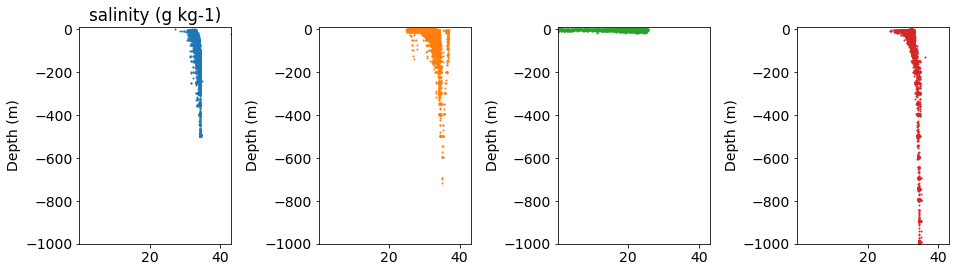

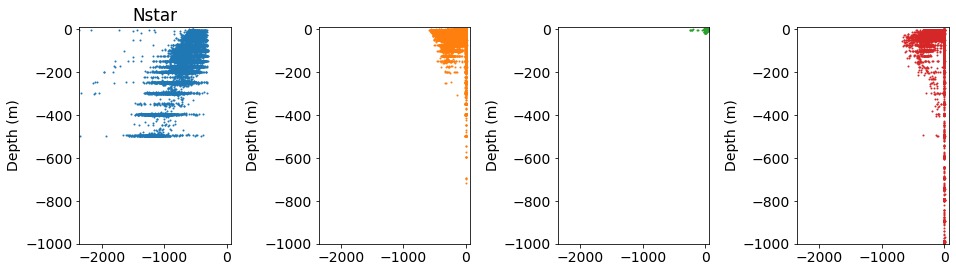

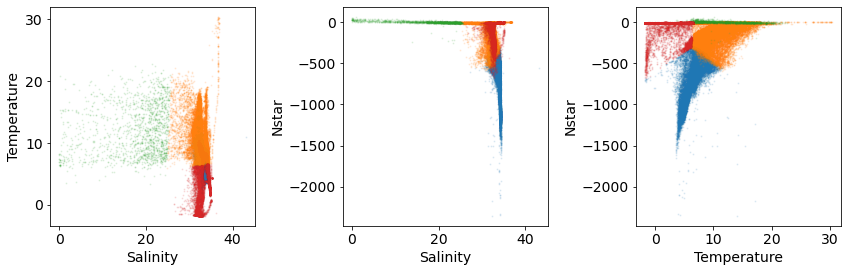

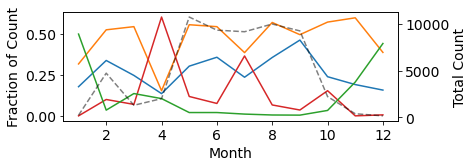

In [32]:
keys = ['temperature (degC)', 'salinity (g kg-1)', 'Nstar']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[2])
for i in range(N):
    z_cluster_plot(df_cluster, keys[2], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,3,figsize = (12,4))
for i in range(N):
    ax[0].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['temperature (degC)'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])
    ax[1].scatter(df_cluster['salinity (g kg-1)'][df_cluster.Cluster == i],df_cluster['Nstar'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])
    ax[2].scatter(df_cluster['temperature (degC)'][df_cluster.Cluster == i],df_cluster['Nstar'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])

ax[0].set_ylabel('Temperature')
ax[1].set_ylabel('Nstar')
ax[2].set_ylabel('Nstar')

ax[0].set_xlabel('Salinity')
ax[1].set_xlabel('Salinity')
ax[2].set_xlabel('Temperature')

plt.tight_layout()

time_cluster_plot(df_cluster)


### DO - Spice
0 (blue) - <br>
1 (orange) - <br>
2 (green) - <br>
3 (red) - <br>

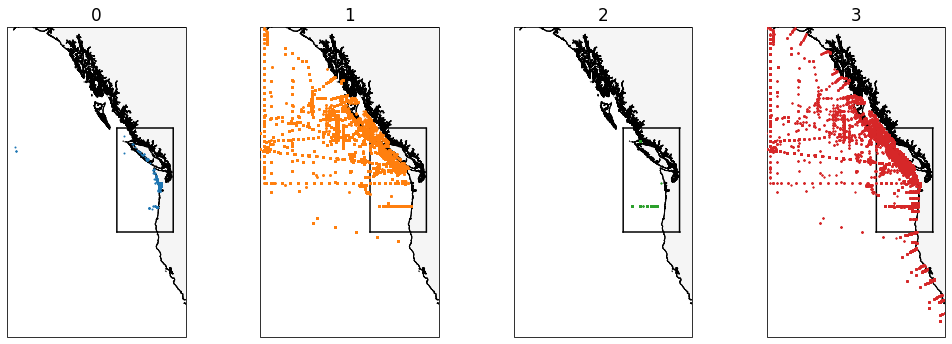

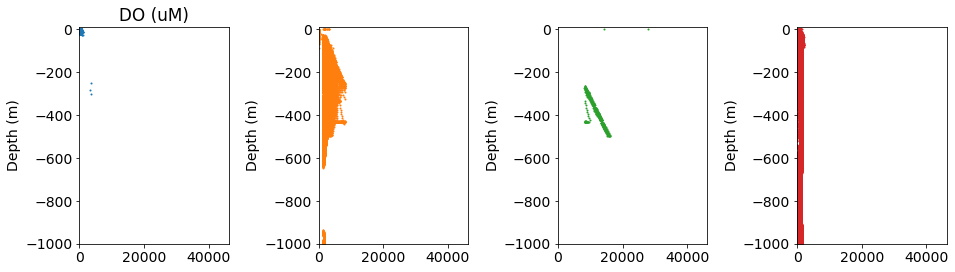

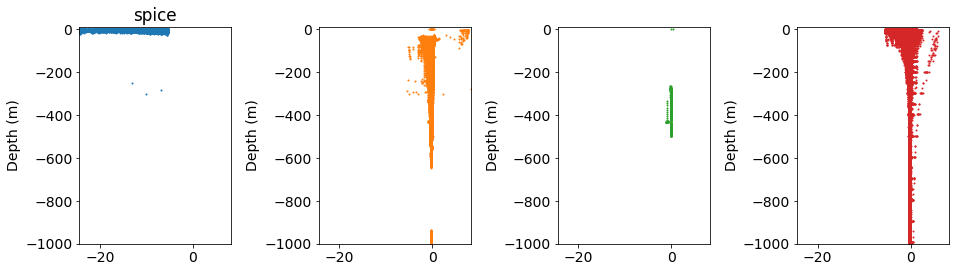

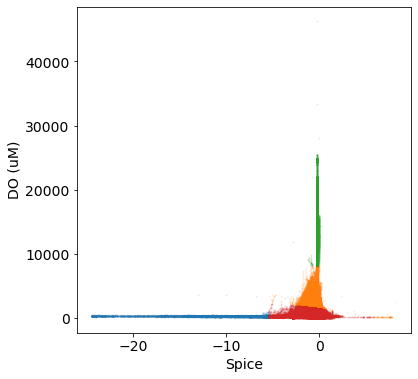

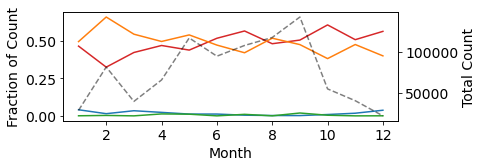

In [33]:
keys = ['DO (uM)', 'spice']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(N):
    ax.scatter(df_cluster['spice'][df_cluster.Cluster == i],df_cluster['DO (uM)'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])
ax.set_ylabel('DO (uM)')
ax.set_xlabel('Spice')
    

time_cluster_plot(df_cluster)

# Nstar - Spice
0 (blue) - Spatial (including depth) and spice overlap with 1, but less -ve Nstar. Not really present in southern waters. No clear seasonal cycle.  <br> 
1 (orange) - See above (more -ve Nstar), also no clear seasonal cycle. <br>
2 (green) - River mouths. Might be stronger in the winter. <br>
3 (red) - Nstar closer to 0 than 0 and 1, goes into deeper and more southern waters but also overlaps with 0 and 1 spatially. Might be more prominent in the summer. <br>

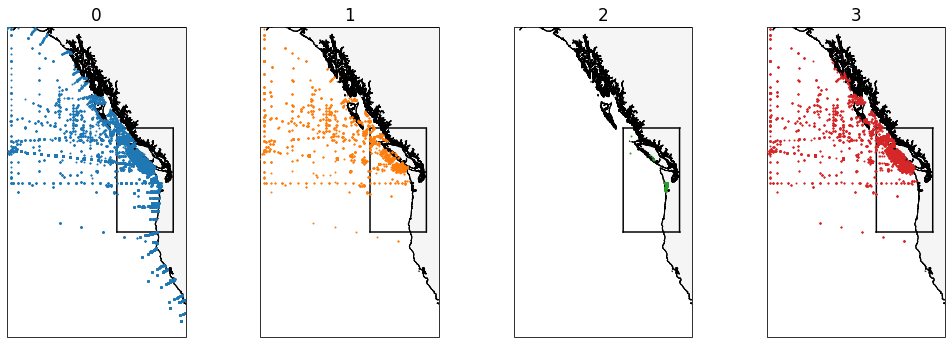

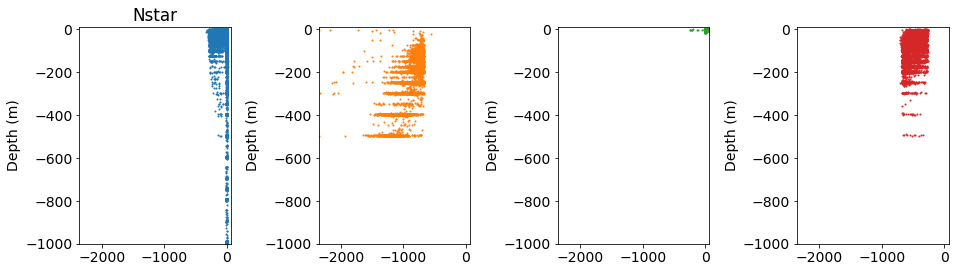

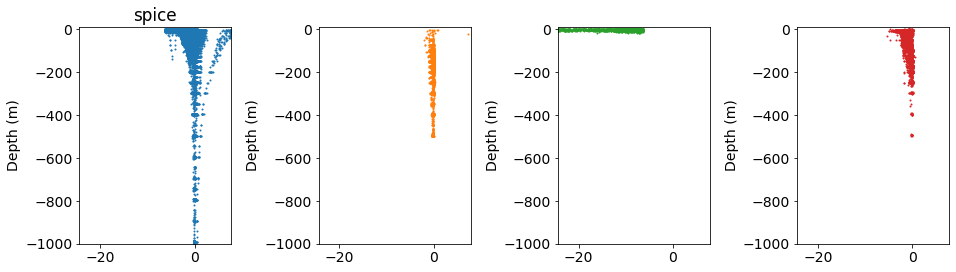

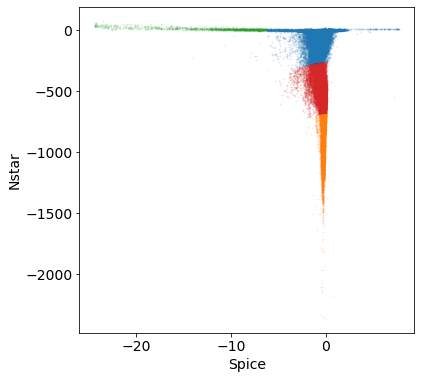

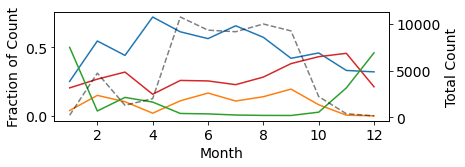

In [34]:
keys = ['Nstar', 'spice']
df_cluster = multi_cluster(obs, keys, N)

fig, ax = plt.subplots(1,4, figsize=(16, 5), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})

for i in range(N):
    xy_cluster_plot(df_cluster, i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[0])
for i in range(N):
    z_cluster_plot(df_cluster, keys[0], i, ax[i], colours[i])

fig, ax = plt.subplots(1,4,figsize=(13.5,4))

ax[0].set_title(keys[1])
for i in range(N):
    z_cluster_plot(df_cluster, keys[1], i, ax[i], colours[i])

# property property
fig, ax = plt.subplots(1,1,figsize = (6,6))
for i in range(N):
    ax.scatter(df_cluster['spice'][df_cluster.Cluster == i],df_cluster['Nstar'][df_cluster.Cluster == i],s=1,alpha=0.1,c=colours[i])
ax.set_ylabel('Nstar')
ax.set_xlabel('Spice')

time_cluster_plot(df_cluster)